### Import Librairies : 

In [36]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings 
import joblib
import json
warnings.filterwarnings('ignore')

%matplotlib inline

In [37]:
plt.rcParams["figure.figsize"] = (9,6)


### Read data : 

In [38]:
df = pd.read_csv('../artifacts/data/ec2_cpu_utilization.csv') # Downloaded from the link above
df.head(20)

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134
5,2014-02-14 14:55:00,0.134
6,2014-02-14 15:00:00,0.134
7,2014-02-14 15:05:00,0.134
8,2014-02-14 15:10:00,0.066
9,2014-02-14 15:15:00,0.132


In [39]:
real_mean = df['value'].mean()
real_std = df['value'].std() 

In [40]:
df['value'].min()

0.066

In [41]:
real_std

0.09481284708142514

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


#### convert timestamp feature from 'object' type to 'timestamp'

In [43]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4032 non-null   datetime64[ns]
 1   value      4032 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 63.1 KB


#### anomalies detected are detected in these timestamps according to the website : 
"2014-02-26 22:05:00",
"2014-02-27 17:15:00"

In [45]:
df[(df['timestamp']=='2014-02-26 22:05:00')] 

,timestamp,value
3547,2014-02-26 22:05:00,2.344


In [46]:
df[(df['timestamp']=='2014-02-27 17:15:00')] 

,timestamp,value
3777,2014-02-27 17:15:00,0.602


#### label our data : 

In [47]:
anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

In [48]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [49]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

#### display the data : 

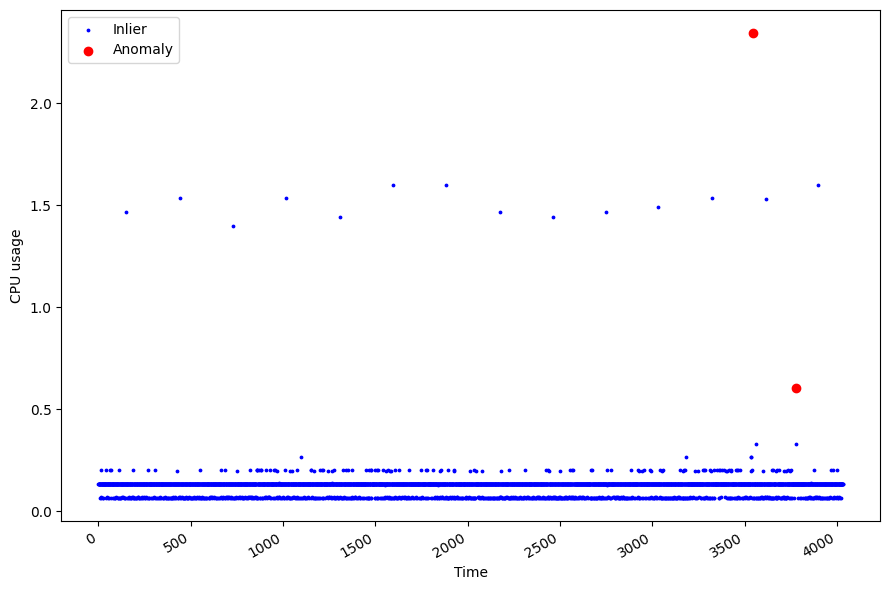

In [50]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

#### devide the data to tain and test data : 

In [51]:
train = df[:3550]
test = df[3550:]

In [52]:
X_train = train['value'].values.reshape(-1,1)


##### in this tutorial we will use the local outlier factor model to detect the anomalies : 

##### initialize the model : 

contamination is the proportion in the dataset , it could be 'auto' or a float value . if a float , the contamination should be in the range [0]

In [53]:
contamination = 1/len(train)

In [54]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(contamination=contamination, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

#### Evaluate the model : 

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [56]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

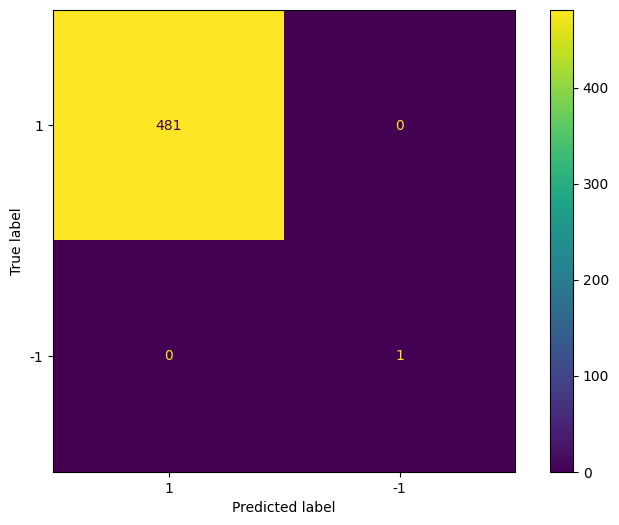

In [57]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

we can see that the model is able to detect the anomaly in the test set . 

#### Save the model : 

In [58]:
import joblib  

In [59]:
def save_model(model_object,model_name) : 
      path='../artifacts/models/' 
      path_to_model=os.path.join("../artifacts/models/",model_name)
      joblib.dump(model_object,path_to_model) 

In [60]:
save_model(lof,'lof.joblib')

#### Load the model : 

In [61]:
def load_anomaly_model(model_folder_path:str) :  
    """
        this function loads the anomaly detection model 
    Args:
        model_path (string): path to the model
    Returns:
        function : anomaly detection model 
    """
    json_pattern = os.path.join(model_folder_path, '*.joblib') 
    models_list = glob.glob(json_pattern) 
    model_path = models_list[0] 
    loaded_model=joblib.load(model_path) 
    return loaded_model


In [62]:
model_folder_path = '../artifacts/models'  

In [63]:
model=load_anomaly_model(model_folder_path)

#### Generate fake data for predictions : 

In [64]:
fake_values = np.random.uniform(low=df['value'].min(),high=df['value'].max(),size=200)

In [65]:
fake_values[0]

1.78415308950835

In [66]:
predicitons = model.predict(fake_values.reshape(-1,1))

In [67]:
data_pred={'values':fake_values,'predections':predicitons}

In [68]:
data_pred = pd.DataFrame(data_pred)

In [69]:
nrml_data = data_pred[data_pred['predections']== 1]
anomalies = data_pred[data_pred['predections']== -1]

#### Visualize the predictions : 

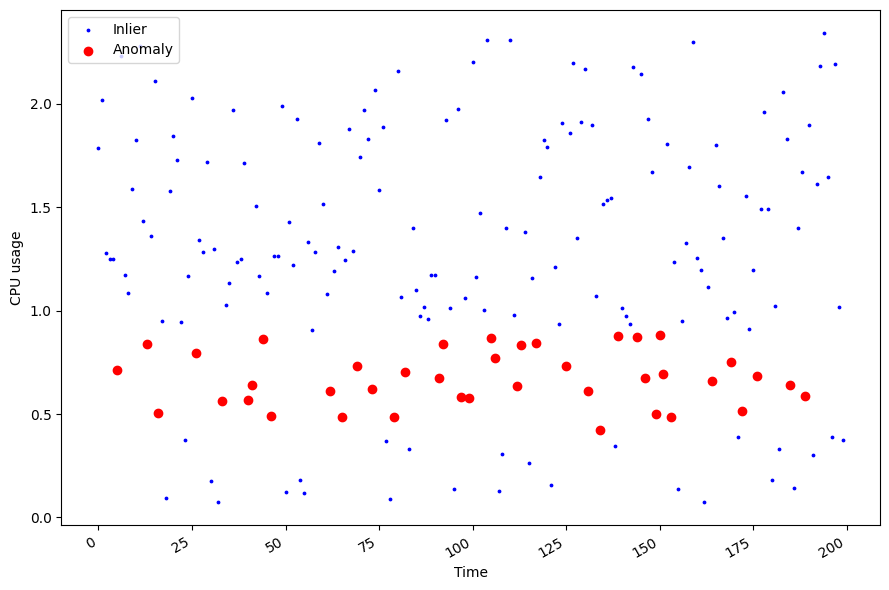

In [70]:
fig, ax = plt.subplots()

ax.scatter(nrml_data.index, nrml_data['values'], color='blue', s=3, label='Inlier')
ax.scatter(anomalies.index, anomalies['values'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()